<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [42]:
%%capture
pip install pyswarms

In [43]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [44]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'

In [45]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [46]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [47]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [48]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [49]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [50]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [51]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [52]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [53]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [54]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


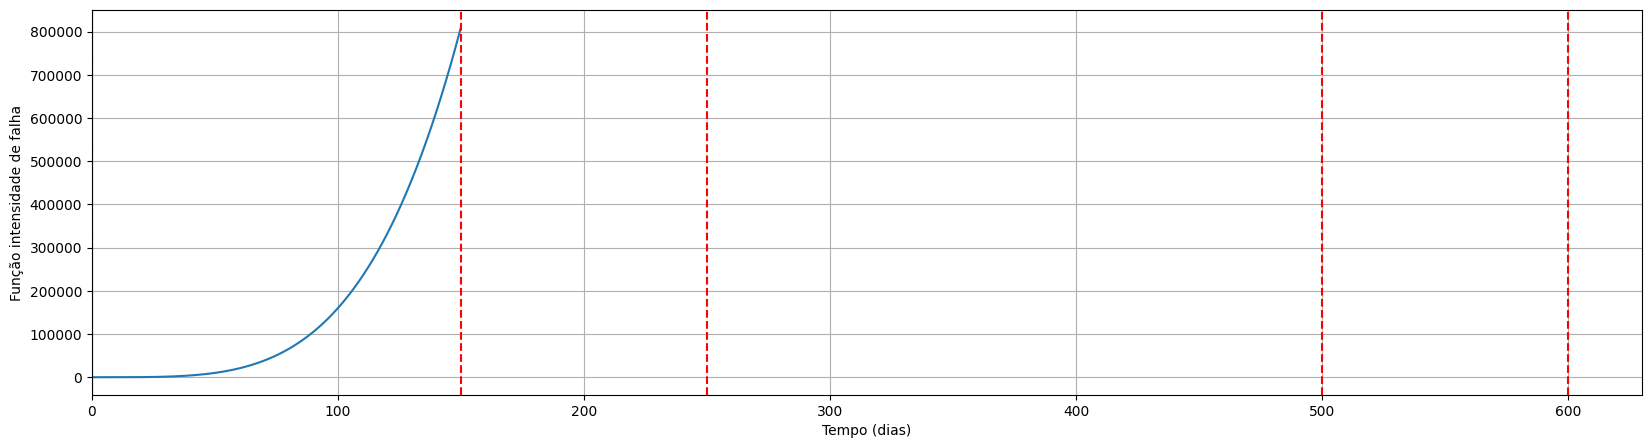

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [55]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [56]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = 730
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [57]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-09-01 02:51:59,058 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  10%|█         |10/100, best_cost=3.91e+10<ipython-input-56-32b84bde5f7e>:83: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:  20%|██        |20/100, best_cost=3.91e+10



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 70, 113, 191, 257, 312, 614, 659, 664]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 537824.0, 2346473.6716028163, 6091534.725162669, 20577336.774660274, 26105655.46290617, 9102382716.702166, 10864909078.718836, 10868912160.16368, 10990221361.045378]
Custo =  289110162113.88007


Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 87, 144, 358, 361, 453, 492, 534, 615, 673]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.77686983985157

pyswarms.single.global_best:  31%|███       |31/100, best_cost=3.91e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 11, 119, 133, 210, 340, 365, 433, 575, 612]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 51.53632, 6541595.126762345, 7435701.578698654, 17479505.66702851, 138968006.79947737, 231107542.78729784, 253812735.29256105, 498656882.7640955, 527024657.2789105, 7237260796.344119]
Custo =  258264984444.6727


Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 17, 42, 253, 318, 351, 364, 414, 599, 627]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588

pyswarms.single.global_best:  54%|█████▍    |54/100, best_cost=3.91e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 39, 92, 150, 211, 409, 436, 459, 585, 609]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 28871.743680000003, 1018533.9970143274, 3095666.942738263, 5489961.595617951, 288355352.34689355, 320001190.58276683, 352418519.7562892, 1021679689.5466337, 1124588779.314594, 2508875565.1317973]
Custo =  100577876336.63617


Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 42, 86, 155, 183, 236, 435, 452, 501, 610]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.77

pyswarms.single.global_best:  75%|███████▌  |75/100, best_cost=3.91e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 154, 222, 243, 270, 322, 351, 387, 427, 451, 493, 521, 560, 596]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 27717469.76768, 71068412.79875188, 71531667.10985507, 100884108.37344885, 123184712.63420632, 125910037.04115513, 153707535.68299454, 162476206.90133396, 194179314.66830704, 209766885.3625562, 275699630.2820983, 401889527.76369274, 426707873.0292259, 2024909238.0399685]
Custo =  93358553322.84398


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 132, 150, 236, 261, 270, 313, 337, 420,

pyswarms.single.global_best:  85%|████████▌ |85/100, best_cost=3.91e+10

Custo =  96317577800.10063


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 48, 157, 192, 217, 315, 347, 454, 584, 629, 658, 660]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.25, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 81537.26976000001, 18015546.57082044, 27494641.28959015, 27908306.356401764, 219523807.54318568, 314757315.5831732, 1214507760.0967631, 1422948942.2757294, 1655528497.6381764, 1826347386.9465473, 1827875369.347405, 1960630850.6462924]
Custo =  116465734192.43803


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 39, 144, 219, 357, 383, 406, 454, 501, 527, 556, 584, 620, 657]
Severidade para cada subsistema: [0.25, 0.

pyswarms.single.global_best:  95%|█████████▌|95/100, best_cost=3.91e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 194, 215, 269, 300, 338, 452, 502, 553, 605]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 87934364.23168, 101189644.1917043, 157356757.26020175, 208649202.48019367, 309583258.1296932, 1250897387.1162324, 1272558606.8088298, 1436480857.9962883, 1672967625.7563343, 3121294276.885088]
Custo =  137897293355.90326


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 86, 204, 249, 270, 343, 434, 452, 505, 555, 591, 663]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.393469340287366

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.91e+10
2023-09-01 02:52:00,516 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.5257867  1.22230429 2.64377784 5.24369059 1.51780378 1.87661263
 1.71667628 1.25168397 5.15350071 5.17425974 6.06119055 3.86776433
 2.71352736 5.38944572 0.76344495 3.0913679  1.17770293 6.83704017
 5.67633634 1.16378619 1.19624414 5.76447481 3.36377848 4.0540066 ]
2023-09-01 02:52:00,518 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 187, 217, 253, 270, 343, 412, 422, 452, 505, 554, 597, 618, 684]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 73174204.70624001, 92224858.31574629, 97859328.27394404, 100795187.16625324, 301183961.52744603, 321235079.19923645, 322654959.8265229, 582964787.9683639, 607212733.2511731, 764665429.6672148, 945182711.7019051, 1039804695.305906, 3999585411.3937464, 4424127640.367792]
Custo =  318636896633.698


Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 50, 77, 271, 333, 452, 685]
Severidade par

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,530 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.5257867  1.22230429 2.64377784 5.24369059 1.51780378 1.87661263
 1.71667628 1.25168397 5.15350071 5.17425974 6.06119055 3.86776433
 2.71352736 5.38944572 0.76344495 3.0913679  1.17770293 6.83704017
 5.67633634 1.16378619 1.19624414 5.76447481 3.36377848 4.0540066 ]
2023-09-01 02:52:00,535 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 0, 68, 132, 188, 273, 405, 426, 453, 507, 563, 625]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.0, 465258.74176000006, 4558860.058557591, 8471713.421721647, 35828307.2516971, 249639353.73784134, 253192962.3253278, 289914826.4557124, 315239817.25396603, 511446565.6905964, 841184402.5745564, 1984165996.2948024]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,547 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.5257867  1.22230429 2.64377784 5.24369059 1.51780378 1.87661263
 1.71667628 1.25168397 5.15350071 5.17425974 6.06119055 3.86776433
 2.71352736 5.38944572 0.76344495 3.0913679  1.17770293 6.83704017
 5.67633634 1.16378619 1.19624414 5.76447481 3.36377848 4.0540066 ]
2023-09-01 02:52:00,548 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 0, 88, 144, 172, 182, 271, 363, 417, 453, 536, 601]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.0, 1688742.13376, 6558928.9235282, 11464703.883118, 11816110.14746014, 40906706.79606746, 120588965.99836406, 133820366.59030241, 184637337.30483377, 453821208.29496604, 754869953.1404963, 2268801692.341213]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,566 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.50656893 1.21660938 2.65791691 5.24772368 1.51960574 1.88366004
 1.70933703 1.21975733 5.16054642 5.17603307 6.05926497 3.86895552
 2.71096575 5.38607358 2.86537513 3.09451212 1.16033199 3.20385744
 5.6532464  1.18283216 1.19660686 3.26730047 3.35678728 4.05710751]
2023-09-01 02:52:00,567 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 84, 182, 335, 369, 453, 528, 565, 587]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1338278.2156800001, 29151904.86514433, 429540911.48053706, 451201961.46861964, 490735619.706162, 713285459.6708409, 836381827.0760919, 917540169.1055162, 8990617208.130846]
Custo =  281851017682.168


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,580 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.50656893 1.21660938 2.65791691 5.24772368 1.51960574 1.88366004
 1.70933703 1.21975733 5.16054642 5.17603307 6.05926497 3.86895552
 2.71096575 5.38607358 2.86537513 3.09451212 1.16033199 3.20385744
 5.6532464  1.18283216 1.19660686 3.26730047 3.35678728 4.05710751]
2023-09-01 02:52:00,581 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 0, 67, 92, 143, 166, 181, 220, 340, 374, 437, 452, 501]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.0, 432040.03424, 786438.9456226513, 5059864.106498401, 5208983.692764949, 5752207.113131471, 9532727.24145896, 113233643.40572485, 117551406.65144362, 137814242.51143572, 157129104.35298768, 264423537.93748367, 4055742177.4020686]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,592 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.49162611 1.22417718 2.62490405 5.2476845  1.52099624 1.88189438
 1.70622768 1.22293489 5.14626897 5.17640022 6.05865681 3.86609167
 2.70445613 5.3844363  3.10200803 3.09368518 1.14563504 1.69634473
 5.66827943 1.14241257 1.19730655 3.65322809 3.34475573 4.07258624]
2023-09-01 02:52:00,597 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 2, 54, 96, 124, 169, 225, 270, 332, 374, 452, 495, 556]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.01024, 138178.70586817554, 873053.2375822188, 2184211.602710806, 2827463.601838603, 9904439.899091205, 12305216.782003067, 20787167.69126554, 26817349.799868762, 60625676.60466231, 148417473.66969377, 356032775.086515, 2728689185.1882377]
Custo =  80223915416.00415


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,606 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.48914588 1.22637914 2.61832741 5.2470787  1.52052791 1.87989402
 1.70761131 1.23551942 5.14225332 5.17616917 6.0593987  3.86535602
 2.70547351 5.38612042 3.49142973 3.09268633 1.14222139 6.62229989
 5.67748894 1.13475264 1.19724255 3.6863438  3.34260219 4.07637859]
2023-09-01 02:52:00,607 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 7, 44, 99, 272, 368, 439, 452, 486, 538, 547, 615, 657, 718]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 5.378240000000001, 40315.888803952876, 1199906.3030778002, 220919994.87290102, 250882154.4160287, 276615086.8495053, 293233494.05062515, 686810169.8507584, 837872019.2550132, 862071044.5093813, 2843229777.704995, 2886834476.592755, 6225798919.238939, 6240489326.015655]
Custo =  426195724038.0141


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,620 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.49586692 1.22804066 2.61478304 5.24565315 1.52007993 1.87777254
 1.71012852 1.24926629 5.1407515  5.17591015 6.06016748 3.86485849
 2.70834694 5.38861553 3.77597993 3.09140339 1.14771148 3.41238584
 5.68555505 1.13335996 1.19697434 3.33897505 3.34416926 4.0794358 ]
2023-09-01 02:52:00,621 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 14, 34, 83, 102, 129, 275, 357, 412, 452, 653, 679, 716]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 7159.168002058815, 529426.0386139029, 938977.1747453031, 1273059.0027439015, 53464963.05717958, 317199577.97886544, 330341051.2237719, 387301022.6590088, 2485299517.2457013, 2657250768.970811, 2707874017.23276, 2827787302.3317113]
Custo =  129065531196.65262


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,635 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.50840045 1.22926438 2.61771203 5.24427605 1.51921228 1.87585439
 1.71271548 1.26191436 5.1408516  5.17535924 6.06110309 3.86451266
 2.71152635 5.39107625 4.32868382 3.09023959 1.16106218 6.21626109
 5.69063143 1.13958598 1.19653817 2.6286996  3.35129941 4.07995368]
2023-09-01 02:52:00,636 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 21, 103, 176, 202, 277, 313, 339, 390, 452, 541, 573, 648, 668, 715]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.25, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 2620765.381365922, 16918118.446181603, 17267325.08034048, 25194438.026655912, 95440867.75954695, 97496658.81407367, 335977967.62679136, 433723256.6366823, 509317060.98921084, 619977750.0571038, 3307692671.6337676, 3326120661.8892307, 3395261579.94957, 3524016691.573805]
Custo =  238999432421.5017


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,645 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52139035 1.22917595 2.62745428 5.2429923  1.51838755 1.87413017
 1.71614544 1.27036209 5.14405544 5.17461495 6.06196235 3.8648355
 2.7143892  5.39321923 5.18723244 3.08938503 1.17580468 1.15514121
 5.69289916 1.15055462 1.19613651 2.21006425 3.35905225 4.07292054]
2023-09-01 02:52:00,646 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 26, 105, 153, 190, 218, 279, 452, 485, 545, 646, 716]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 3802.0403200000005, 2671208.747678087, 7896777.232346549, 8464962.060013251, 8974298.277630612, 82230373.78540577, 1539894295.1136158, 1550305719.2438436, 1738978959.4408271, 5266180499.5410595, 5905541423.22495, 5922925676.552023]
Custo =  234245382156.69516


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,654 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.53324019 1.22886506 2.63961373 5.24187435 1.51750688 1.87315609
 1.71930551 1.27471885 5.1485901  5.17385672 6.06265732 3.86589197
 2.71690105 5.39451763 5.34497789 3.08903512 1.18937771 2.63121696
 5.69127392 1.1611283  1.19579429 2.02520857 3.36697098 4.0616222 ]
2023-09-01 02:52:00,655 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 104, 181, 246, 280, 422, 452, 510, 555, 644, 718]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 3893289.2876800005, 25118289.066820174, 29243741.781684186, 71626948.72478905, 185706644.33868226, 192780212.63415822, 990908640.4013982, 1134473537.7788334, 1264915407.44883, 1401769201.1773112, 1416459607.9540267]
Custo =  96610654374.58334


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,662 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.5435444  1.22811975 2.65128964 5.2412689  1.51679895 1.87272594
 1.72171323 1.27829402 5.15305919 5.17319177 6.0628988  3.86705374
 2.71892772 5.3955918  5.7814027  3.08919529 1.1999146  3.5058168
 5.68919995 1.17089472 1.19558149 1.80953425 3.37373893 4.05047741]
2023-09-01 02:52:00,663 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 102, 150, 255, 280, 313, 412, 426, 452, 529, 643]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 3533058.5702400003, 9884656.25612735, 26161212.209328443, 31411777.39954714, 33645991.95793013, 77020243.84565833, 91236383.6381111, 317913101.76913106, 371521950.49891365, 1177951787.581042, 2075535914.1714845]
Custo =  115435302181.52942


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.91e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 28, 99, 177, 261, 279, 332, 413, 452, 645]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 5507.317760000001, 1870200.6666395199, 17663104.875491038, 26823721.013483986, 49518711.62104952, 55727054.89278941, 83715544.93277375, 139010277.9257828, 2014017212.0182137, 2885898705.61293]
Custo =  93807206213.99583


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,671 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.55251075 1.22574025 2.66070003 5.24111894 1.51628517 1.87298861
 1.72328321 1.27821097 5.1570907  5.17289529 6.06267432 3.86822905
 2.71924294 5.39607481 6.08814506 3.08935782 1.20736442 4.11679042
 5.68401544 1.17955841 1.19539857 1.78801517 3.37719404 4.04101715]
2023-09-01 02:52:00,672 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,681 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.55979019 1.22266007 2.66494584 5.24146094 1.51625488 1.87388755
 1.72300504 1.27480764 5.16065166 5.17282712 6.0624486  3.86928304
 2.71857762 5.39624165 6.7383301  3.08996745 1.21317625 4.23120017
 5.67808488 1.18



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 24, 33, 95, 263, 279, 326, 341, 411, 452, 512, 547, 648]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 2548.0396800000003, 5383.386448097437, 1191845.4455642884, 188074868.35638413, 188595641.92972124, 193277516.47385138, 194289826.79040322, 593404010.7560918, 652044182.7785805, 683165469.1275796, 785180551.730161, 4356740116.653747, 4527652411.791266]
Custo =  197372654196.35187


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,695 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.55786111 1.21986516 2.66867693 5.24237412 1.51635416 1.8751077
 1.72273681 1.26701534 5.16212543 5.1728829  6.06221197 3.87008065
 2.71685017 5.39517749 6.47094545 3.09055846 1.20940068 3.99244894
 5.67253748 1.18473506 1.1953015  1.83179558 3.37824818 4.03124608]
2023-09-01 02:52:00,696 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 20, 40, 93, 263, 277, 309, 352, 452, 480, 594, 611, 652]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1024.0, 14199.106130376404, 892472.9480966651, 191081527.4692629, 191507941.76490065, 193543801.4811657, 198671440.45375526, 255771356.30529118, 303666618.18740994, 911698198.4985418, 984149212.3394274, 1025194711.1984353, 1182723464.590298]
Custo =  64988221486.0562


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,705 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.55333868 1.21747297 2.67143155 5.24333259 1.51650883 1.87627139
 1.7211826  1.25935077 5.16212952 5.17329674 6.06181614 3.87062869
 2.71466991 5.39313708 6.23441311 3.09113912 1.19692937 3.61455061
 5.66861105 1.18284383 1.19536909 1.96153372 3.37661152 4.02984114]
2023-09-01 02:52:00,706 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 46, 83, 92, 260, 275, 313, 444, 452, 484, 551, 601, 655]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 335.54432, 36137.881581221736, 399185.133584555, 531202.1676967955, 76743023.69908242, 77196750.8649258, 80017418.32878366, 184053585.6104383, 255495331.86547783, 265400736.5290305, 490918407.1938906, 1835591798.7660398, 2170687541.629133, 2918409316.967681]
Custo =  228208997519.73584


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,715 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.54358    1.21643622 2.67049402 5.24424712 1.51698016 1.87737749
 1.71872384 1.2518672  5.161855   5.1738574  6.0613603  3.87107035
 2.71252758 5.39025547 5.75404298 3.09166632 1.18036681 3.013411
 5.66534053 1.17732854 1.19551005 1.83564153 3.37433984 4.03430803]
2023-09-01 02:52:00,717 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 11, 50, 91, 142, 174, 180, 252, 273, 453, 657]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 51.53632, 68672.39913239022, 651216.37566464, 4809012.4591282, 5134004.935350541, 5163683.894082636, 10810999.98387573, 34929269.0686443, 294356719.4238201, 1136656796.7309978, 1860386599.2726367]
Custo =  67295270053.04849


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.91e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 9, 52, 91, 183, 230, 245, 272, 304, 453, 493, 620, 658, 667]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 18.895680000000002, 90712.10387079562, 639600.3159228687, 22586501.74893393, 24222939.255697556, 35488699.19744882, 65730181.66854563, 67656190.1751866, 220574476.68530554, 708133399.3984778, 1537560987.9526858, 1766858735.6443307, 1774422035.092755, 1887535496.1009548]
Custo =  122548065155.21487


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,731 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.5325628  1.2155548  2.66377299 5.24498887 1.51750896 1.87835396
 1.71601415 1.24510545 5.15925906 5.17444568 6.06090044 3.87065099
 2.71077653 5.38765535 5.67013106 3.0920696  1.16497394 2.16572732
 5.66310013 1.17023376 1.19574632 1.83701238 3.36981113 4.04317783]
2023-09-01 02:52:00,732 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,744 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52206272 1.21547092 2.65389087 5.2453776  1.51799109 1.87916177
 1.71363658 1.24063192 5.15581409 5.17493334 6.06052473 3.86958904
 2.70997466 5.38567927 4.97081508 3.09228785 1.15464575 2.0810671
 5.66183484 1.162



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 8, 50, 66, 92, 159, 189, 271, 360, 404, 453, 546, 592, 618, 658, 678]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 10.48576, 76274.16551531802, 136346.52454587526, 505140.4266457565, 9268289.043518776, 9635441.83370685, 34679640.09770602, 330422707.45367926, 338858030.3189223, 412111412.0279331, 2063631981.1172135, 2252380451.598581, 2271113254.4577956, 2312170152.050359, 2441757631.55307, 2527484013.3347006]
Custo =  148856905781.8267


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,758 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.51282827 1.2159786  2.64378699 5.24522498 1.51840196 1.8798422
 1.71219893 1.23896411 5.15224639 5.17526869 6.06024235 3.86811818
 2.70949323 5.38396786 4.65771853 3.09244035 1.14751991 2.35790579
 5.6644256  1.15577631 1.19625253 2.57143021 3.36158514 4.06110739]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 8, 47, 94, 178, 195, 271, 362, 405, 453, 532, 573, 604, 658, 687]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 10.48576, 54992.64432870821, 834356.5700603934, 18484229.08651518, 18640415.015041113, 99790274.11355914, 408930899.7895494, 417126358.00010693, 488558291.3872937, 733666089.5202903, 879603911.1624479, 1744353166.7800584, 2085381510.2844858, 3446495882.1015005, 3512660401.2345343]
Custo =  382908886133.51086


2023-09-01 02:52:00,759 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,768 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.50793464 1.21668691 2.63469077 5.24475353 1.51867587 1.88024307
 1.71104003 1.23938109 5.14934917 5.17554124 6.06001954 3.86674409
 2.70957689 5.38340298 3.9596095  3.0923092  1.14298688 2.58033687
 5.66979314 1.15152461 1.19649433 2.67600902 3.35858914 4.06705512]
2023-09-01 02:52:00,769 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 8, 40, 69, 96, 141, 203, 219, 271, 361, 400, 446, 452, 496, 526, 627, 656]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 10.48576, 23307.84379936688, 157771.23352539842, 611784.164113068, 1663681.57586328, 3935789.8185913665, 4151656.046539672, 59945721.3653738, 135396093.39388728, 142125410.7496121, 206075236.17305297, 207137376.676365, 754657546.0572792, 828484677.2694621, 3954701999.1695476, 3981539162.9595723, 4126358534.336462]
Custo =  20

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,777 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.50821514 1.2179735  2.62705732 5.24419983 1.5186898  1.88049323
 1.71085785 1.24010642 5.14764153 5.17572987 6.0601486  3.86566703
 2.71003242 5.38364966 3.90824836 3.09191879 1.14361581 2.53282368
 5.67562801 1.14814859 1.19668748 2.36939784 3.35702217 4.07105363]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 9, 34, 97, 146, 209, 272, 320, 360, 452, 539, 543, 573, 654, 719]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 18.895680000000002, 9226.355126775728, 1316472.953719526, 5756619.945267247, 8297092.587494483, 24578173.036590006, 125689800.59620991, 130586383.03152719, 893090312.5877628, 1185966311.4017682, 1196267273.409547, 1873702121.6122873, 4876253052.797868, 4988679475.058445, 5002050718.889551]
Custo =  317856047250.0306


2023-09-01 02:52:00,778 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 99, 151, 273, 322, 359, 452, 595, 651, 719]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 32.0, 2569135.2212193143, 7970555.767236877, 37231236.223152295, 42096495.571086936, 46373176.625101976, 95055070.35517481, 959941362.6840792, 1301412901.1169283, 5027777895.787881, 5041149139.618987]
Custo =  277087352184.712



2023-09-01 02:52:00,793 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.51275254 1.21921128 2.62194519 5.24357229 1.51869797 1.88065173
 1.71168828 1.24245651 5.14686441 5.1755664  6.06034582 3.86493365
 2.71047263 5.38550284 3.88853704 3.09152377 1.15013403 2.77740167
 5.68105055 1.14809039 1.19677431 1.60269226 3.35659949 4.07164789]
2023-09-01 02:52:00,795 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,803 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.51743904 1.22089577 2.61906403 5.24301859 1.51845908 1.87961898
 1.71365929 1.24527964 5.14700566 5.17540871 6.06059815 3.86427841
 2.71134275 5.38738228 4.52635269 3.09113268 1.1569255  3.05458905
 5.68494113 1.15108613 1.19669837 0.69932736 3.35717087 4.06883593]
2023-09-01 02:52



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 11, 100, 274, 351, 452, 508, 519, 594, 649, 719]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 51.53632, 2660393.4668560363, 230054792.2971829, 245877181.88186777, 304264717.92918134, 437232511.3231499, 461380815.1733392, 535643191.3412769, 866088513.130722, 992075398.0016395, 1005446641.8327454]
Custo =  66814833027.51835


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,813 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52254015 1.22256093 2.61699747 5.24264448 1.51824313 1.87785109
 1.71562404 1.24800098 5.14843271 5.1752423  6.06095299 3.86393845
 2.71231749 5.38963341 5.60307108 3.09081316 1.16357073 3.47648433
 5.6882001  1.15709687 1.19653687 0.65700065 3.35886841 4.06526473]
2023-09-01 02:52:00,814 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 14, 87, 101, 276, 327, 345, 452, 493, 628, 648, 685, 719]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 1214591.486290869, 1508287.1526947296, 139024278.44022843, 144528866.58504808, 145860045.77678415, 212448107.42191404, 294217459.39938027, 1245543846.0034206, 1993689803.885292, 2036649646.094686, 2082826646.9568377, 2176445262.7170815]
Custo =  236424721113.9467


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.91e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 62, 102, 179, 208, 223, 276, 339, 452, 557, 648, 679]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 188233.5522726672, 1064901.577238374, 7345251.100187257, 7811055.471502358, 8021650.346060671, 69201513.37084542, 104335021.06417823, 179984597.3938359, 609471330.802346, 1219877686.8307285, 2605465803.7904177, 2688898209.9404187]
Custo =  238598388523.84442


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,823 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52779917 1.22402512 2.62223856 5.24241511 1.51798542 1.87592039
 1.7174854  1.25093052 5.1501004  5.17495221 6.06129076 3.86464965
 2.7134042  5.39164765 6.70757862 3.09055651 1.17048637 4.02946538
 5.68856653 1.16365204 1.19632685 0.3369092  3.3616026  4.06196419]
2023-09-01 02:52:00,824 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.91e+10



Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 19, 30, 103, 142, 175, 203, 243, 277, 313, 337, 391, 452, 529, 553, 598, 612, 648, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 792.3516800000001, 3096.106512158788, 2020949.746247276, 5159109.048244952, 5511259.217325364, 15099139.408615198, 20703010.15501272, 61279008.35613602, 63854562.94040717, 65651408.739575066, 76400094.78955987, 172102990.40640914, 225711839.13619176, 296155656.36

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,839 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.53211565 1.22509647 2.62961154 5.24230235 1.51770956 1.87432188
 1.71892656 1.25369982 5.1517537  5.17462177 6.06159097 3.86610731
 2.71438336 5.39342481 6.76193463 3.09043906 1.1777165  4.3740695
 5.68804526 1.169583   1.19612195 6.60051097 3.36425482 4.05874718]
2023-09-01 02:52:00,840 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.91e+10



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 20, 34, 82, 102, 172, 197, 247, 277, 319, 338, 452, 568, 575, 603, 649, 663]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 5833.192461863875, 491571.5765748575, 921928.602272562, 13390905.73978531, 13691494.816669336, 50651174.157923825, 86655069.92249632, 90223748.74669033, 91547483.25115956, 1032861612.2376988, 1565720556.4238431, 1588551601.603625, 2366631615.5450068, 4059163205.700343, 4636625174.183361, 4760739539.856384]
Custo = 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,849 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.53415859 1.22586849 2.63971249 5.24248145 1.51747178 1.87312828
 1.7201697  1.25580381 5.1537528  5.17421883 6.06175175 3.86790245
 2.71513803 5.39464611 6.478423   3.09060288 1.18422041 4.42614344
 5.68539394 1.17329575 1.19596433 5.22409741 3.36663473 4.054679  ]
2023-09-01 02:52:00,850 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,859 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.53567753 1.22584007 2.64986009 5.2429381  1.51731283 1.87208138
 1.7212412  1.25665051 5.15549185 5.1738581  6.06179622 3.86951089
 2.71556011 5.39540831 5.94972405 3.09082169 1.18823244 4.18202984
 5.68163911 1.17



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 21, 39, 67, 102, 192, 250, 276, 313, 344, 452, 517, 545, 591, 651]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 1306.9123200000001, 11996.794318657712, 127305.87015014926, 884046.4722430591, 26443679.546622023, 29734341.1124389, 60675963.88523239, 63372261.66632218, 66177200.05617307, 134213934.53193852, 305300150.4941621, 383916524.74143434, 571440146.1098574, 641891041.4668653, 802701340.5655644]
Custo =  60306773470.29092


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.91e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 21, 42, 101, 144, 171, 190, 251, 275, 349, 412, 452, 544, 652]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 1306.9123200000001, 18122.05735818013, 1391177.9285771374, 5057230.105954759, 5277593.389738165, 10342756.224812865, 22105897.294084966, 50345148.946764335, 64608465.586609535, 81445435.46480228, 138405406.90003914, 220435749.34272346, 1006492466.5864003, 5524580429.049764]
Custo =  278927030581.41583


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,952 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.53597433 1.22527385 2.65755039 5.24338366 1.51725809 1.87168873
 1.72149017 1.25593708 5.15680295 5.17365215 6.06170983 3.87084526
 2.71549876 5.39466967 5.8942394  3.09108974 1.1894411  3.80359107
 5.67732212 1.17510839 1.19587269 0.95228323 3.36963068 4.04740052]
2023-09-01 02:52:00,953 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,961 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.53567729 1.22443394 2.66236306 5.24385319 1.51730403 1.87277896
 1.72116533 1.25466413 5.1574871  5.17358814 6.06158053 3.87117964
 2.71520472 5.39294249 6.4078569  3.09139246 1.19036327 3.49083174
 5.67328544 1.17



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 20, 44, 61, 100, 190, 250, 274, 322, 355, 396, 452, 654]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1024.0, 24321.20678066866, 70914.01478049724, 860009.963633758, 25430947.650335032, 28989076.681776624, 56815671.82463685, 61497104.59601799, 64939051.16055507, 71974104.57188994, 157751633.6048293, 7494265628.802868, 8254085940.536505]
Custo =  198951687426.899


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,970 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.53520744 1.22318707 2.66343038 5.24424886 1.51739205 1.87490063
 1.72008759 1.25350557 5.15772378 5.17371915 6.06143199 3.87072878
 2.71474141 5.39066506 6.04854917 3.09165989 1.18745929 2.86441802
 5.66992794 1.17208749 1.19607726 3.8602377  3.36874758 4.04453875]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 18, 45, 77, 98, 130, 162, 192, 248, 274, 413, 452, 588, 655]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 604.6617600000001, 29638.809707738677, 259322.26610811474, 643404.6264577827, 2451619.2191841714, 2715471.9862383716, 4322480.942462512, 7295109.180055796, 37340334.5323904, 139819905.22731942, 150110860.18785268, 917053414.5552998, 1349595341.6106658, 2097317116.9492135]
Custo =  97677818715.00235


2023-09-01 02:52:00,971 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 15, 44, 96, 195, 231, 246, 273, 441, 452, 496, 629, 655, 663]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 29285.273124464333, 990280.5987479537, 31521836.86396698, 32488813.98539066, 43941171.27367765, 49165232.69895517, 250045356.40707487, 252107929.52821875, 269177477.99452084, 1204284489.4502997, 2214136863.3735156, 2260250517.8329935, 2384364883.506017]
Custo =  226283660532.47842



2023-09-01 02:52:00,980 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.5337875  1.22201738 2.66196908 5.24458448 1.51757838 1.8771762
 1.71812233 1.25192246 5.15731229 5.17397391 6.06123065 3.869677
 2.71400206 5.38827505 5.9143455  3.09182747 1.18462921 2.4036183
 5.66789332 1.16788598 1.1962079  1.38124146 3.36670447 4.04652571]
2023-09-01 02:52:00,982 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:00,991 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.53016991 1.22103416 2.65555502 5.24475056 1.51776343 1.87915587
 1.71615732 1.25048089 5.15674264 5.17428725 6.06104297 3.86871272
 2.71326802 5.38638114 5.59631448 3.0918609  1.18057627 1.90145
 5.66759828 1.16334968 1.19633244 6.61901666 3.3645327  4.04885004]
2023-09-01 02:52:00,992



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 13, 42, 95, 120, 199, 243, 273, 417, 452, 503, 523, 553, 601, 655, 668]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 24518.60434056033, 973414.4503325075, 2002095.9843630441, 6234881.217263887, 7907403.879227994, 41854351.75684691, 157200864.01610762, 165983813.1228049, 833416663.8413687, 879970181.9189315, 894784587.5544568, 932956419.6890472, 994433152.7318151, 1547601326.1849132, 1658054748.4030294]
Custo =  258040139794.5708


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.91e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 11, 39, 68, 94, 152, 202, 241, 273, 437, 452, 515, 544, 612, 655, 673]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 51.53632, 17767.731557861025, 144917.40086159896, 546693.9546757728, 2707334.0745242643, 4024556.9972623587, 5309079.06371593, 41414723.76836357, 225324267.00303763, 228272144.9757202, 390359187.70500064, 471464708.12906456, 812194078.5938532, 2458135381.497204, 2474935657.4489446, 2572609686.7123265]
Custo =  215472585249.97183


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,004 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52602823 1.22028547 2.64674511 5.24461702 1.51794033 1.8806955
 1.71442428 1.24921203 5.15533218 5.17456629 6.06090358 3.86760855
 2.7126425  5.38558164 5.67529918 3.0917948  1.17636926 1.42932839
 5.66896313 1.15933925 1.19642933 4.15228321 3.3625276  4.05205018]
2023-09-01 02:52:01,006 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.91e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 10, 37, 81, 93, 205, 274, 313, 445, 452, 503, 565, 654, 677]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 32.0, 13943.389722916263, 426456.8164875745, 608009.0952606268, 21976409.579102155, 28276710.612109214, 104102691.64534032, 210768178.37780356, 219530305.14199123, 242031206.41689628, 467058890.515257, 604111588.2339784, 753355352.0534015, 841407053.5102707]
Custo =  72287940251.78088


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,021 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52225108 1.21969889 2.63792839 5.24422429 1.51808006 1.88116742
 1.71332209 1.2483456  5.15354089 5.17478313 6.06083362 3.86661744
 2.7122593  5.38538645 6.34922293 3.09170914 1.17289959 0.78573887
 5.67232085 1.15693279 1.19649008 1.65459427 3.36082803 4.05514734]
2023-09-01 02:52:01,022 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,031 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.51937226 1.21925461 2.63116277 5.24379053 1.51815603 1.88158616
 1.71282883 1.24819254 5.15192772 5.17497535 6.06086719 3.865977
 2.71218164 5.38611819 6.93444169 3.09155587 1.17083074 1.15290623
 5.6765424  1.1561



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 10, 35, 93, 128, 208, 274, 423, 452, 503, 530, 581, 653, 679]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 32.0, 10276.292139331119, 1007882.1099454938, 2867143.6227215226, 7686229.553707641, 13361072.365814013, 968218417.151605, 974972062.575584, 1642404913.294148, 1710154146.5338402, 2905471224.8042555, 3000418252.502228, 4167596074.6502476, 4251028480.8002486]
Custo =  374952445996.63007


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,043 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.51702231 1.2191267  2.62751149 5.24339587 1.5181572  1.88140101
 1.7125762  1.24909224 5.15059609 5.17499404 6.06091759 3.86563917
 2.71237704 5.38734777 6.56672931 3.091402   1.16942087 1.3559675
 5.68029421 1.15647644 1.19643915 3.71623544 3.35895606 4.05983635]
2023-09-01 02:52:01,044 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 12, 33, 94, 123, 154, 208, 240, 275, 356, 442, 452, 481, 517, 562, 576, 620, 653, 679]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 6682.180052450733, 1122493.9898379012, 2436299.7762206635, 2649533.3339799577, 7771306.72372019, 8650899.770780379, 49160462.84574566, 67593319.02623717, 106234495.08194801, 118882340.93870217, 169080722.97676358, 253698988.8561598, 281093569.7427

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 14, 32, 96, 209, 242, 275, 352, 408, 452, 491, 564, 592, 652, 678]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 5076.832667914306, 1296051.3090320255, 48180746.84941667, 49134989.67730661, 87431541.47157568, 103379322.30872771, 116529945.69725649, 180302502.3305116, 648393895.7017549, 922712236.015485, 1645191187.5282135, 2017699596.382322, 3177977331.9379573, 3263703713.7195873]
Custo =  390248718237.9199



2023-09-01 02:52:01,055 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.51719928 1.21993073 2.62883592 5.24304266 1.51806572 1.8811713
 1.71326888 1.25037584 5.15008244 5.17480637 6.06097874 3.86567415
 2.71285324 5.38888888 5.62144599 3.09125967 1.16878975 1.28804726
 5.68250083 1.15681323 1.19638739 1.02115428 3.35938081 4.06023181]
2023-09-01 02:52:01,056 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,066 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.51866701 1.22129849 2.63171986 5.24290785 1.51793276 1.88012228
 1.71420253 1.25157129 5.14981474 5.17455848 6.06108316 3.86590201
 2.71335149 5.39029386 4.75347847 3.09114929 1.16954415 1.90666146
 5.68305948 1.15789419 1.19632528 5.18893167 3.35976486 4.05999587]
2023-09-01 02:52:



Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 16, 32, 97, 145, 207, 244, 276, 325, 347, 442, 452, 481, 537, 560, 584, 651, 675]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 4652.763096801742, 1374947.587955208, 5602731.225642623, 7984419.5756598925, 9191982.893611778, 46929586.32363923, 51938009.31845085, 53710100.04077687, 772632076.2379906, 785279922.0947448, 1109024312.777536, 1273024982.226683, 1284137147.1123576, 1297853510.5348532, 1381522263.35

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,078 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52017609 1.22274256 2.63464142 5.24296361 1.51778465 1.87815536
 1.71544224 1.25267667 5.14982349 5.17427995 6.06118711 3.8665347
 2.71383714 5.39144787 4.25131459 3.09111118 1.17053247 2.78235502
 5.68275662 1.15985953 1.19625726 1.94888833 3.36036186 4.05821352]
2023-09-01 02:52:01,079 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 18, 32, 88, 98, 123, 166, 206, 230, 245, 276, 302, 344, 452, 504, 529, 620, 651, 672]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 604.6617600000001, 4373.195641051841, 783798.5266182997, 972315.0009639428, 1224254.0492125931, 1774409.5646945578, 4877196.298823014, 5348013.45254055, 16613773.39429181, 17933977.89471434, 19299716.043024786, 23866346.41461839, 91903080.89038384, 209799122.6611608

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,089 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52249564 1.22400522 2.63884455 5.24314622 1.51765338 1.87609583
 1.71685268 1.25363758 5.15026828 5.17402707 6.06128157 3.86737042
 2.7142266  5.39237548 4.17201313 3.09114555 1.17215168 3.47038702
 5.68151216 1.16204336 1.19619508 5.95123331 3.36096846 4.05601311]
2023-09-01 02:52:01,090 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 19, 33, 83, 99, 163, 204, 217, 247, 276, 303, 342, 452, 504, 524, 590, 621, 651, 669]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 792.3516800000001, 5056.701351635515, 542448.8885076179, 850220.2733071914, 4097492.9464533925, 4964323.064205195, 5895840.802088351, 28541614.63023505, 62891361.69002652, 64353423.855681546, 68308050.35316007, 976778232.1623578, 1094674273.9331348, 1141579089.8558

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,102 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.5255638  1.22479484 2.64359981 5.24335904 1.51754161 1.87427145
 1.71809862 1.2544075  5.15160952 5.17382936 6.06136464 3.86819789
 2.7144453  5.39271959 4.2816704  3.09118787 1.17401657 4.34977984
 5.6796498  1.16443982 1.19614048 2.53966256 3.3623068  4.05365005]
2023-09-01 02:52:01,103 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 19, 34, 70, 100, 154, 203, 248, 276, 300, 342, 452, 650, 667]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 792.3516800000001, 5937.732134711199, 190986.27332992476, 785920.2796189534, 2738103.139242785, 4010998.177833903, 37941267.75281943, 71157403.64638399, 72343248.53678381, 76823015.98800872, 147830054.37894663, 2159898942.025845, 2262404083.565766, 2375517544.5739655]
Custo =  83266008733.56883


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,111 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52834307 1.22525349 2.64790342 5.24358693 1.51749592 1.87313632
 1.71911193 1.25495937 5.1531731  5.17368743 6.06143286 3.86893745
 2.71449272 5.39223825 4.42155798 3.09124819 1.17621417 5.06000508
 5.67702212 1.16647313 1.19609691 5.94182562 3.36360145 4.05162716]
2023-09-01 02:52:01,112 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 19, 35, 100, 147, 201, 248, 275, 323, 345, 437, 452, 620, 651, 666]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 792.3516800000001, 6955.409079402465, 1531053.9008170965, 5895195.401896163, 7459757.197758403, 42842848.9040647, 74455657.99882315, 79182923.60503443, 80918070.08128457, 746510678.0875921, 765825539.9291441, 5677887981.639204, 5853919292.606709, 5867050761.90713, 5982859925.0380945]
Custo =  193483758481.2673


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,119 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.53046054 1.22556306 2.65081993 5.24380058 1.51753529 1.87302437
 1.71952925 1.25462812 5.15464495 5.17360558 6.06144074 3.86931656
 2.71447916 5.3911822  4.88060924 3.09131722 1.1783455  5.10536818
 5.67457135 1.16756455 1.19606916 1.95267051 3.3647998  4.04988812]
2023-09-01 02:52:01,120 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 19, 36, 99, 199, 247, 275, 317, 349, 394, 435, 452, 550, 651, 665]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 792.3516800000001, 8125.044689962008, 1412674.7995994936, 34766132.54860432, 36866547.43030784, 69598737.65203696, 73095485.0419617, 76190647.97284718, 84236637.95058261, 134896981.9874928, 284818974.0072768, 656696922.8518026, 1369957205.8141365, 1954442658.0907722, 2072983596.8140833]
Custo =  265646920104.6787


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 17, 37, 98, 140, 170, 198, 245, 275, 353, 400, 432, 452, 487, 563, 652, 665]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 454.35424000000006, 10153.607627813317, 1302718.6798775138, 4502416.549861418, 4768487.385235354, 6409232.063634512, 40097070.07616339, 75061117.09406123, 91603805.9479272, 100701821.38520813, 137677767.0010116, 141850328.90052357, 153320187.05487844, 440346900.82733643, 576057388.8151739, 652781175.9502094, 771322114.673520

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,377 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.53156189 1.22487997 2.65323079 5.24396587 1.51764598 1.87353834
 1.71934681 1.25404114 5.1558216  5.17354422 6.06144467 3.86962192
 2.71421469 5.38976614 5.73315333 3.09138056 1.18007758 4.72316598
 5.67259309 1.16801155 1.19605171 5.2762067  3.36563815 4.04895676]
2023-09-01 02:52:01,379 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Custo =  68688484280.821014


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,397 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.53224893 1.22422284 2.65264045 5.24405762 1.51776735 1.87457735
 1.71904153 1.25317212 5.15675189 5.17354417 6.06143557 3.86955041
 2.71384621 5.38844905 6.07434937 3.09143737 1.18124815 4.101922
 5.67093951 1.16763083 1.19606603 1.4039394  3.36591378 4.0484967 ]
2023-09-01 02:52:01,398 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 15, 38, 87, 98, 123, 198, 244, 275, 325, 357, 452, 582, 627, 652, 665]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 12837.768077202914, 632003.9068530208, 838501.7862314279, 1974764.964898329, 5580587.0955290515, 38036014.18377324, 74112801.90965149, 79314834.549068, 82664180.51570478, 133647731.26661432, 823557069.1261677, 1053291330.2893223, 1193870626.1918423, 1737137317.2514482, 1855678255.9747593]
Custo =  249556091728.8314


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,420 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.53257871 1.22320284 2.6495758  5.2440932  1.51788169 1.87609888
 1.71808743 1.25203387 5.15731311 5.17363103 6.06141011 3.86919837
 2.71344727 5.38744352 6.97306173 3.09148382 1.18141036 3.59606241
 5.66992724 1.16701974 1.19608748 5.50044898 3.36601968 4.0483374 ]
2023-09-01 02:52:01,422 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 14, 39, 83, 97, 147, 164, 197, 243, 274, 412, 452, 506, 530, 549, 602, 653, 666]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 15529.024031546089, 466724.2645443205, 716134.4437056192, 5376670.055154393, 5462538.65497985, 5963923.938542218, 12792672.404495658, 48341770.39024822, 148279810.4567858, 158968541.32453984, 184124746.25277737, 243753593.81826138, 297125791.8794567, 341573142.61207324, 2257

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,441 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.53254718 1.22211398 2.64669388 5.24404238 1.51797275 1.8775395
 1.71709791 1.2509696  5.15755129 5.17375878 6.0613396  3.86878778
 2.71308828 5.38692953 0.78489353 3.09151428 1.18139668 3.36425557
 5.66908001 1.16564598 1.19613154 2.2441157  3.36557461 4.04893431]
2023-09-01 02:52:01,443 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 13, 39, 85, 96, 198, 213, 242, 274, 325, 418, 452, 512, 585, 654, 668]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 16234.552298762712, 538553.6347634054, 728528.193794038, 34307427.973816365, 34485850.30811335, 54669581.00448398, 56027829.77970719, 61428732.82858787, 100539725.37716207, 108965682.2884234, 946515030.8044022, 1260862146.362697, 1706529578.8754978, 1790842925.7715158, 1901296347.9896321]
Custo =  137644716790.5499


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,455 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.53250632 1.22113459 2.64396357 5.24397403 1.51803538 1.87866492
 1.7161126  1.25017456 5.15700139 5.17395071 6.06123919 3.86839369
 2.71277023 5.38695885 2.21361729 3.09154089 1.18137257 2.69792571
 5.66843683 1.1641328  1.19620249 6.57816342 3.36506786 4.05060119]
2023-09-01 02:52:01,456 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 12, 39, 88, 95, 152, 199, 225, 241, 274, 429, 452, 506, 654, 669]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 16981.37519472842, 662452.4234737981, 780531.4180734924, 6908098.6673669545, 8003721.230878593, 8501968.279031796, 19722140.899424553, 57458474.61953628, 208124409.7862646, 213100481.8605502, 935184580.738642, 2196687602.9231215, 2287776093.928337, 2395604733.500816]
Custo =  131798685680.45955


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,470 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.53123435 1.22057923 2.64148385 5.24383234 1.51803663 1.87925748
 1.71538116 1.24960552 5.15573912 5.1741821  6.06114789 3.86797502
 2.7125968  5.38698697 3.99912939 3.09152084 1.18047711 1.71313056
 5.66865973 1.16272934 1.19626902 3.24604256 3.36450054 4.0525863 ]
2023-09-01 02:52:01,471 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 12, 39, 95, 122, 201, 215, 241, 274, 325, 421, 452, 517, 545, 570, 654, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 16981.37519472842, 1040752.0907338099, 2225936.8917382956, 6548482.169837762, 7524447.359421142, 25406825.467565686, 26837308.559330843, 32238211.608211517, 75084776.47621071, 82485394.95162751, 253571610.91385108, 332187985.1611234, 345350534.7113273, 914823286.5801438, 1019783916.66577, 1122467145.3053906

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,484 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52991068 1.22021562 2.63945551 5.24370221 1.51798238 1.87905859
 1.71506677 1.24964086 5.15458348 5.17439385 6.06107202 3.8675654
 2.71263127 5.38709024 5.82535249 3.09145956 1.17889895 0.68606207
 5.66909916 1.16152069 1.19632776 0.17127682 3.36387305 4.05452912]
2023-09-01 02:52:01,486 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 13, 38, 95, 202, 238, 241, 274, 359, 452, 653, 672]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 14041.095905990122, 1063696.159073648, 39547744.44905602, 40608978.63429722, 42781729.88679353, 80518063.60690525, 101573252.25127193, 150255145.98134476, 2248253640.5680375, 2366824769.201212, 2466986569.822494]
Custo =  85809547465.31221


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,499 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52800133 1.22005989 2.63864472 5.24358424 1.51790617 1.87885919
 1.71489374 1.25023911 5.15333539 5.17457509 6.06101421 3.86723992
 2.71279998 5.38781414 0.92967981 3.09140078 1.17745806 6.61522189
 5.66965131 1.16045425 1.19637608 4.11674227 3.36328073 4.05620232]
2023-09-01 02:52:01,500 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 14, 38, 95, 137, 154, 203, 237, 241, 274, 356, 398, 446, 452, 485, 536, 559, 623, 653, 673]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75, 0.25, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 13418.8785114946, 1063073.9416791524, 3999548.716358145, 4068947.3800097457, 8094961.587312762, 9037155.731124492, 11926179.631490232, 13356662.723255388, 32310685.962242, 39748676.25909107, 107097509.85049394, 1

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,509 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.5256451  1.22043264 2.63864991 5.24348693 1.51783018 1.87821551
 1.71509058 1.25087365 5.15221874 5.17473612 6.06097132 3.86702886
 2.71299926 5.38892148 3.47961719 3.09134238 1.17621178 4.98862954
 5.67033786 1.16027817 1.19638569 0.98505748 3.36285893 4.05727736]
2023-09-01 02:52:01,510 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 15, 37, 96, 204, 242, 274, 354, 403, 452, 487, 599, 652, 673]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 11039.787507615461, 1155740.2876186816, 41553816.76928551, 42791649.74344073, 79435257.39071628, 97083020.5270698, 107089101.52735966, 179733797.01133335, 191203655.16568822, 801697876.3959007, 860551295.2224361, 880621165.4254793, 978295194.6888611]
Custo =  52149125350.90922


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,531 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52353215 1.22101704 2.63978239 5.24343921 1.51775764 1.87754273
 1.71565141 1.25158375 5.15143763 5.17473833 6.06094312 3.86695457
 2.71324382 5.38991883 5.90463774 3.09129515 1.17510745 3.09127766
 5.6719795  1.16084962 1.19636597 5.58759283 3.36274527 4.05803019]
2023-09-01 02:52:01,537 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 16, 36, 64, 96, 204, 222, 242, 275, 353, 452, 506, 527, 595, 606, 652, 673]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 9052.430324056379, 105826.03120821026, 647611.6712225765, 19977752.688911874, 20246088.759693366, 34389523.91836931, 35837342.82302853, 52380031.67689451, 108214156.63212079, 233509250.30711666, 284040333.5293889, 2017226617.5792606, 2023678732.6667194, 3748011366.803685, 3880477965.17356, 3978151994.436942]
Custo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,559 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52193781 1.22190357 2.64101586 5.24342919 1.51769736 1.87682859
 1.71621542 1.25222911 5.15076478 5.17465831 6.06098367 3.86711293
 2.71352068 5.39068839 0.73553076 3.09125812 1.17480515 1.79002705
 5.67421883 1.16174137 1.19631654 2.75020795 3.36289185 4.05841684]
2023-09-01 02:52:01,560 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 21 5
Tempos para manutenções preventivas: [0, 17, 35, 64, 97, 144, 170, 203, 233, 243, 275, 305, 351, 409, 433, 452, 503, 524, 560, 572, 652, 672]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 454.35424000000006, 7416.303847290017, 108343.42619199741, 691525.0659738235, 1909712.4932754645, 2111166.0726298676, 13330303.024766123, 14043739.190924397, 21395094.854416

pyswarms.single.global_best:   0%|          |0/1, best_cost=3.91e+10



Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 17, 35, 62, 98, 174, 202, 225, 244, 275, 351, 412, 426, 452, 505, 520, 570, 600, 651, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 454.35424000000006, 7416.303847290017, 89533.92641297466, 756796.8754572961, 6389951.001744824, 6788138.3975583445, 8855354.719156297, 22773647.706912734, 24077886.779951528, 39447711.97161427, 55300437.965768926, 69516577.7582217, 296

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,573 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52087885 1.22271597 2.64245248 5.24343473 1.51764791 1.87617505
 1.71676668 1.25266846 5.15095713 5.17458506 6.06104351 3.86734176
 2.71377179 5.39108967 3.08796897 3.09123244 1.17485432 0.88561913
 5.67643154 1.16267826 1.19626829 0.12986253 3.36308758 4.05767644]
2023-09-01 02:52:01,576 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,599 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52018118 1.22334551 2.64387901 5.24347233 1.51763616 1.87565022
 1.71725076 1.25300632 5.15154507 5.1744786  6.06110579 3.86758618
 2.71393134 5.39108051 5.66282906 3.09121903 1.17511261 0.22044957
 5.67841385 1.16



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 17, 34, 98, 174, 201, 233, 245, 275, 351, 433, 452, 488, 569, 651, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 454.35424000000006, 6300.218822799328, 1393675.850369415, 15740513.94293028, 16107736.476305967, 35128945.49376898, 44203097.27043916, 79167144.288337, 94536969.47999975, 127483977.46972921, 152316598.49735853, 164339569.56407693, 488726130.3741902, 605660250.0611024, 1466381370.4445562, 1569064599.0841768]
Custo =  220770844852.18533


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,617 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52112171 1.22378284 2.64513355 5.24352817 1.51764863 1.87518159
 1.71758209 1.25298133 5.15257836 5.17434986 6.06116629 3.86782542
 2.7140083  5.39085898 1.58480539 3.0912347  1.17545038 0.65638218
 5.68016458 1.16482831 1.19618314 3.7586048  3.36364905 4.05534957]
2023-09-01 02:52:01,619 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 17, 34, 98, 200, 222, 246, 275, 316, 351, 452, 496, 651, 670]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 454.35424000000006, 6300.218822799328, 1393675.850369415, 36248052.471068524, 36611533.11793002, 54610115.677706435, 55780208.613065906, 59097837.68756894, 62724250.46517373, 121111786.5124873, 212002384.83770007, 1547875797.1731448, 2361434426.153798, 2466673134.9746323]
Custo =  228761122678.64844


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,636 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52237654 1.2238401  2.64603245 5.24360507 1.51767631 1.87514239
 1.71770038 1.25284532 5.15361795 5.17420791 6.06122742 3.86802786
 2.71400398 5.39052077 4.7322549  3.09124938 1.17629921 2.02265665
 5.68070103 1.1655429  1.19615596 1.7486503  3.36394044 4.0538463 ]
2023-09-01 02:52:01,637 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 16, 34, 98, 177, 199, 215, 246, 275, 312, 352, 404, 452, 484, 601, 652, 669]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 6548.475332005145, 1393924.1068786208, 17429128.96860612, 17679775.75889028, 17881841.258613795, 40867450.685165726, 74716675.93957973, 77384502.8584436, 81925691.17424054, 362124453.252493, 432961943.8053167, 490358607.5102621, 1148666241.0318763, 1204322540.54161, 1308049974.8602757, 1415878614.4327545]
Custo = 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,650 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.5241069  1.22350137 2.6462449  5.24368431 1.51773223 1.87512015
 1.71777792 1.25257843 5.15454984 5.17408402 6.06127791 3.86813841
 2.71397338 5.38990021 0.97077693 3.09129548 1.177433   2.60741797
 5.68018682 1.16606683 1.19615215 0.2530287  3.36417216 4.0525102 ]
2023-09-01 02:52:01,652 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 15, 35, 97, 125, 199, 246, 275, 353, 431, 452, 546, 576, 652, 669]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 8057.39516470411, 1284622.9689333022, 2638798.481749662, 6147665.088709345, 8133933.472900436, 41983158.727314435, 58525847.581180416, 87852412.4785648, 115509161.45351475, 202058891.78112024, 307284988.7262357, 3097819888.771912, 3822753332.327295, 3930581971.8997736]
Custo =  355151912557.02026


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 15, 35, 97, 199, 246, 275, 353, 408, 452, 580, 653, 668]
Severidade para cada subsistema: 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,780 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52601091 1.22317848 2.64589329 5.2437566  1.51779504 1.87539749
 1.71768394 1.25217682 5.15514975 5.1740009  6.0613152  3.86819571
 2.71394087 5.389293   4.53810451 3.09135624 1.17850259 3.67082452
 5.67936425 1.16625431 1.19616045 5.53146065 3.36430108 4.05139779]
2023-09-01 02:52:01,782 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


[0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 8057.39516470411, 1284622.9689333022, 35496603.26378887, 37482871.64797996, 71332096.90239397, 87874785.75625995, 100609138.38475043, 164381695.01800552, 3034704174.667595, 3509478567.29608, 3522763786.3200784, 3633217208.5381947]
Custo =  140216885609.19507


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,804 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52770058 1.22278815 2.64545485 5.24381864 1.51785367 1.87571135
 1.71756758 1.25171648 5.15551485 5.17393032 6.06131394 3.86819203
 2.71390943 5.38878262 1.15163651 3.09141334 1.17943251 4.52849447
 5.67825989 1.16602831 1.19618753 3.33019934 3.36437088 4.05052692]
2023-09-01 02:52:01,805 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 14, 36, 97, 148, 164, 199, 245, 275, 354, 412, 452, 592, 620, 653, 668]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 9892.530056720272, 1256325.7927313864, 6145500.628840435, 6223539.959044832, 8487441.375325162, 41482923.68445143, 76446970.70234928, 93601890.16950019, 108055007.4956418, 165014978.93087864, 986825609.6194137, 1117074799.822287, 2375251465.430179, 3012286114.8788805, 3122739537.096997]
Custo =  387433198166.1823


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,817 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52898013 1.22230246 2.64473654 5.24385722 1.51790031 1.87616306
 1.71731796 1.25129578 5.15524347 5.17394655 6.06128535 3.86815637
 2.7138042  5.38841395 5.09038356 3.09145738 1.17981453 4.69478083
 5.67689057 1.16543847 1.1962135  0.97204904 3.36430579 4.05071799]
2023-09-01 02:52:01,818 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 14, 37, 96, 199, 228, 244, 275, 355, 418, 427, 452, 580, 625, 653, 669]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 11546.969676583114, 1156247.469787649, 35802930.56449911, 36429589.364923134, 48224024.96123903, 84300812.68711728, 102085660.94092493, 119700886.0760129, 128751918.33234154, 134294374.91144782, 331841587.02012503, 558756816.9343215, 584014485.0371655, 598380220.8909862, 706208860.463465]
Custo =  56646394182.37543


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.91e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 14, 37, 96, 200, 235, 244, 274, 356, 452, 595, 653, 669]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 11546.969676583114, 1156247.469787649, 36897536.49868009, 37865196.35925479, 44608221.896583065, 45829155.02728313, 64783178.26626974, 116948048.34702235, 981834340.6759267, 1341845221.1736908, 2024786243.5903196, 2132614883.1627984]
Custo =  234649652331.50082


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,835 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52964221 1.22186574 2.6439879  5.24387521 1.51793011 1.87664476
 1.71690478 1.2509208  5.15456595 5.17396894 6.0612398  3.86808534
 2.71365258 5.38816788 1.36934385 3.09147812 1.17986082 4.19892005
 5.67564096 1.16469858 1.19624084 5.98067948 3.36422974 4.05139617]
2023-09-01 02:52:01,836 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,843 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52977845 1.22155955 2.64328716 5.24388563 1.51791962 1.8770743
 1.71646963 1.2507689  5.15393781 5.1740449  6.06119156 3.86796913
 2.71350047 5.38807364 4.89122744 3.09148635 1.17950082 3.30093047
 5.67455899 1.163



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 14, 37, 96, 201, 243, 274, 319, 356, 415, 452, 540, 589, 653, 669]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 11546.969676583114, 1156247.469787649, 38019467.24475355, 39542569.74649737, 75091667.73224993, 79128535.17112969, 83284725.43532056, 435684533.15336186, 487692879.1864754, 787205746.9913094, 986318721.6990409, 1390934367.773418, 1405300103.6272388, 1513128743.1997175]
Custo =  102357158137.02036


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.91e+10



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 14, 37, 96, 139, 202, 243, 274, 319, 357, 422, 452, 558, 582, 607, 653, 670]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 11546.969676583114, 1156247.469787649, 4343259.545533676, 6684454.694521079, 35260698.13247913, 70809796.11823168, 74846663.55711144, 79226063.61538795, 160073308.8702919, 201021641.60079783, 318875732.46956694, 404980311.5107856, 421663681.48232317, 2156695694.014187, 2261038359.3053794, 2366277068.12621

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,853 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52928508 1.22141162 2.6426886  5.243863   1.51790088 1.87742686
 1.71610179 1.25084386 5.15327023 5.17413167 6.06114795 3.86785763
 2.71336676 5.38812508 1.67506965 3.09147937 1.17909211 2.38772512
 5.6735962  1.16310827 1.19628787 0.712361   3.36401818 4.05396885]
2023-09-01 02:52:01,853 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.91e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 15, 37, 96, 202, 210, 243, 274, 324, 357, 452, 653, 670]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 11039.787507615461, 1155740.2876186816, 39168724.04246577, 39243936.93116034, 62461873.42906818, 63750294.417858206, 68902666.58228432, 72412373.61516389, 123395924.36607343, 2221394418.952766, 2325737084.2439585, 2430975793.0647926]
Custo =  80834867727.34299


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,864 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52801125 1.22144249 2.64242686 5.24381039 1.51785867 1.8775235
 1.71581612 1.25103175 5.15266966 5.17421681 6.06111023 3.86774432
 2.7132921  5.38825212 5.74031961 3.09145314 1.17855332 2.19636354
 5.67284508 1.16244161 1.1963072  4.55033966 3.36383153 4.05508785]
2023-09-01 02:52:01,865 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,874 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52622544 1.22169269 2.64243838 5.2437517  1.51781967 1.87734524
 1.71565669 1.25122476 5.1522258  5.1743031  6.06108744 3.86764767
 2.71327849 5.38865006 1.95355616 3.09142255 1.17783614 1.58251686
 5.67251808 1.162



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 15, 37, 96, 171, 203, 243, 275, 357, 396, 447, 452, 652, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 11039.787507615461, 1155740.2876186816, 14372624.972907875, 14890562.380769756, 16274252.589198798, 53461831.573378794, 72561161.21549112, 79061901.50473222, 152244030.29771197, 153119172.2722704, 2222160816.55444, 2340035806.474589, 2442719035.114209]
Custo =  86832597308.272


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,883 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52452531 1.22195905 2.6426743  5.24369291 1.51778267 1.87712589
 1.71553384 1.25144673 5.15202612 5.17437216 6.06109535 3.8675786
 2.71332801 5.38908257 5.5310881  3.09138035 1.17715671 0.7634554
 5.6727928  1.16212582 1.19632649 4.49661544 3.36352402 4.05626095]
2023-09-01 02:52:01,884 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 16, 36, 97, 130, 156, 203, 243, 275, 317, 357, 452, 526, 613, 652, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 9052.430324056379, 1255485.6929987224, 3119962.472436706, 3274543.422294533, 7042022.923500192, 12645893.669897713, 49833472.65407771, 53330220.04400244, 58091138.325861245, 235647255.85331923, 451270141.2236874, 920164881.4018934, 1147879724.5073552, 1165549807.0295618, 1268233035.6691823]
Custo =  81398606015.13976


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,895 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52303157 1.22228085 2.64300621 5.24363977 1.51775179 1.87679756
 1.71553249 1.25166614 5.15220131 5.17443383 6.06112679 3.86752
 2.71339476 5.3895284  1.07717794 3.09134197 1.17654831 0.52986903
 5.67343399 1.16211952 1.19630938 0.83043117 3.36341486 4.05648845]
2023-09-01 02:52:01,896 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 36, 97, 203, 230, 244, 275, 357, 435, 452, 621, 652, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 9052.430324056379, 1255485.6929987224, 39968224.84719061, 40539192.901322015, 50904968.06095646, 57259059.035834864, 76358388.67794718, 106501057.6748837, 128553522.81913747, 5102044513.607397, 5279137364.207221, 6097585665.155265, 6200268893.794886]
Custo =  332909743728.49036


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,905 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.522043   1.22257137 2.64351029 5.24360192 1.51773807 1.87645913
 1.71556484 1.25186674 5.1526955  5.17444669 6.06116213 3.86751455
 2.71348567 5.38990598 3.99175566 3.09131297 1.17627922 1.21230448
 5.67452396 1.16211707 1.19627487 4.43008408 3.36332204 4.05644505]
2023-09-01 02:52:01,905 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 16, 36, 97, 177, 203, 244, 275, 324, 357, 447, 452, 484, 609, 652, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 9052.430324056379, 1255485.6929987224, 17535125.718689796, 17889997.726193056, 19360385.310236044, 55437173.0361143, 60397520.73490286, 63907227.767782435, 777602417.9320164, 783818952.1877828, 841215615.8927281, 1601937824.2032652, 1645730232.581959, 1663400315.1041656, 1766083543.743786]
Custo =  89547020724.90329


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,916 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52165848 1.22282643 2.64397029 5.243575   1.51774231 1.87615793
 1.71580471 1.2520133  5.15334076 5.17440634 6.06119698 3.8675301
 2.71357254 5.390216   6.76005561 3.09129603 1.17627166 2.57936958
 5.67577352 1.16217823 1.19623783 0.85996747 3.36324433 4.05614154]
2023-09-01 02:52:01,917 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 16, 36, 97, 140, 155, 203, 215, 245, 275, 356, 452, 550, 579, 652, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 9052.430324056379, 1255485.6929987224, 4534232.402827313, 4592346.146224696, 5805819.053894352, 6628316.776411863, 28541427.628152415, 29777447.450035337, 48210303.630526856, 100375173.71127948, 472253122.5558053, 575741995.2412485, 672361982.7351457, 1490810283.6831894, 1593493512.32281]
Custo =  220963446213.2301


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,926 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52166976 1.22305218 2.64434186 5.2435602  1.51774649 1.87590011
 1.71614111 1.25211933 5.15395615 5.1743571  6.0612282  3.86758775
 2.71364954 5.39031613 2.72759652 3.09129047 1.176606   3.21994886
 5.67692868 1.16265258 1.19620466 4.68514777 3.36322087 4.05554954]
2023-09-01 02:52:01,927 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 36, 97, 202, 245, 275, 356, 430, 452, 502, 573, 652, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 9052.430324056379, 1255485.6929987224, 38801328.800280765, 40437494.0455827, 75401541.06348054, 93834397.24397206, 120034517.44023971, 149120267.78992736, 798778773.1332265, 1079660169.4087958, 1600515849.9633212, 1618185932.4855278, 1720869161.1251483]
Custo =  118793776458.13702


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,939 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52245796 1.22319605 2.64467411 5.24357741 1.51775599 1.87575729
 1.71651492 1.25212782 5.15438586 5.17428988 6.06125364 3.86768929
 2.71369473 5.39034397 5.78167645 3.09130837 1.17705379 3.26359283
 5.67780262 1.16318479 1.19618176 1.31206459 3.36332235 4.05492195]
2023-09-01 02:52:01,940 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 16, 36, 97, 157, 201, 245, 275, 307, 355, 390, 432, 452, 533, 596, 652, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 9052.430324056379, 1255485.6929987224, 8612970.773237122, 9582706.811322236, 11296448.865441853, 46260495.883339696, 48251859.135216795, 54636689.36368407, 82328659.91850217, 133109977.85190213, 137282539.7514141, 392478524.126931, 673251511.707912, 737084098.1285089, 1555532399.0765529, 1658215627.7161734]
Custo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,948 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52377056 1.22314759 2.6449105  5.2435972  1.51777782 1.87574102
 1.71688574 1.25202328 5.15451241 5.17422671 6.06126429 3.86780221
 2.71369857 5.39033865 1.697051   3.09133375 1.17762518 3.12138189
 5.67832792 1.16369366 1.19617934 5.46255599 3.36348889 4.05423097]
2023-09-01 02:52:01,949 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 16, 36, 97, 201, 245, 275, 326, 355, 415, 431, 452, 541, 594, 652, 670]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 9052.430324056379, 1255485.6929987224, 37662577.41196423, 39376319.46608385, 74340366.4839817, 79792922.8870974, 82629582.8949663, 98362656.07133283, 115507257.99911013, 299738615.76013225, 375332420.1126608, 600758385.2980373, 958665357.6906374, 975178527.0992167, 1080417235.9200509]
Custo =  103326629740.66193


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:01,957 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.5249949  1.2228957  2.64506943 5.24363106 1.51780249 1.87579144
 1.71717949 1.25191516 5.15432929 5.17417619 6.06127379 3.86790182
 2.71366029 5.39008222 4.96225552 3.0913629  1.17815506 2.76035809
 5.67868494 1.16416665 1.19619576 2.25924857 3.36369927 4.05360791]
2023-09-01 02:52:01,958 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 16, 36, 97, 200, 245, 275, 306, 355, 412, 452, 499, 597, 653, 670]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 9052.430324056379, 1255485.6929987224, 36551458.463225454, 38345457.85610943, 73309504.87400728, 75181887.91462114, 81806576.09824559, 412926248.02989197, 469886219.46512884, 489158495.23412806, 988814705.3318129, 1052991733.2223624, 1782286921.216391, 1887525630.0372252]
Custo =  241223653731.3753


pyswarms.single.global_best:   0%|          |0/1

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,092 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52628317 1.22249616 2.64514056 5.24367566 1.517825   1.87597398
 1.71741691 1.25179921 5.15414886 5.17414493 6.06127707 3.86797649
 2.71360859 5.38967766 1.57978397 3.09139031 1.178612   2.69140625
 5.67885928 1.16448937 1.19622187 5.89467102 3.36389602 4.05307422]
2023-09-01 02:52:02,093 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 15, 36, 97, 199, 213, 244, 275, 354, 428, 452, 504, 575, 623, 653, 670]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 9452.703984974225, 1255885.9666596402, 35467866.261515215, 35630063.553795986, 57869015.722447835, 64223106.69732624, 81378026.16447715, 107212822.10272548, 139191354.40050548, 257087396.17128244, 541648101.464305, 2036654634.4777884, 2064172064.6870465, 2793467252.681075, 2898705961.5019093]
Custo =  344723968184.06573


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,102 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52733376 1.2221174  2.64496898 5.24371787 1.51784214 1.87623242
 1.71753315 1.25166199 5.15392646 5.17412438 6.06126731 3.86799649
 2.71355708 5.38929145 5.40181667 3.0914107  1.17888736 2.33721211
 5.67869445 1.16458975 1.19624969 2.1362027  3.36405854 4.05260423]
2023-09-01 02:52:02,103 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 15, 36, 97, 129, 165, 198, 244, 275, 300, 355, 402, 445, 452, 487, 566, 577, 653, 670]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.75, 0.75, 0.25, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 9452.703984974225, 1255885.9666596402, 3009018.9763842337, 3367855.250099347, 3877020.705598723, 36332447.79384291, 72409235.51972117, 73668086.48394036, 81865091.14103766, 331225103.84000003, 389691849.45172536, 390945212.23395735, 402415070

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,111 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52811105 1.22182499 2.64459466 5.24375118 1.51785063 1.87652301
 1.71740974 1.25154032 5.15372525 5.17413151 6.0612373  3.8680135
 2.71350731 5.3889796  1.3556277  3.09142729 1.17889772 1.37227473
 5.67829695 1.16464765 1.19627337 5.98321674 3.36413702 4.05246912]




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 15, 37, 97, 128, 198, 236, 244, 275, 355, 400, 443, 452, 482, 563, 653, 670]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 11039.787507615461, 1227879.4026917305, 2874465.359356017, 5844624.511138789, 29453043.671426237, 35461861.47897927, 71538649.20485753, 89323497.45866518, 97786973.3359154, 155260217.206626, 235516103.3354343, 572863225.031324, 884832904.2386842, 4184655652.754861, 4913950840.74889, 5019189549.569724]
C

2023-09-01 02:52:02,112 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.91e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 14, 37, 97, 165, 199, 243, 275, 356, 452, 536, 575, 653, 670]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 11546.969676583114, 1228386.584860698, 11505967.590326218, 12054252.456035297, 18459785.661800474, 55647364.64598047, 74080220.82647198, 126245090.9072246, 399829528.2131259, 539617797.503406, 648069414.9025751, 1377364602.896604, 1482603311.7174382]
Custo =  220608280833.71915


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,124 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.5287187  1.22156733 2.64422746 5.24376478 1.51785568 1.87679166
 1.71715491 1.25147102 5.15350627 5.17414825 6.06119969 3.86800995
 2.71346274 5.38874721 4.60413638 3.09143946 1.1785855  1.36162618
 5.67768541 1.16445503 1.19628966 2.39544655 3.36412114 4.05235518]
2023-09-01 02:52:02,125 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 14, 37, 97, 129, 200, 243, 275, 356, 452, 539, 543, 571, 653, 670]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 11546.969676583114, 1228386.584860698, 2981519.594585291, 6140752.85001985, 36054661.036641896, 73242240.0208219, 91675096.2013134, 143839966.28206602, 436715965.09607136, 447016927.1038501, 1071684131.1619872, 4090868164.43283, 4106341478.532857, 4211580187.353691]
Custo =  281933877382.8683



2023-09-01 02:52:02,134 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52916189 1.22139595 2.64376926 5.24377025 1.51785578 1.87700999
 1.71687945 1.25144782 5.15330808 5.17417534 6.06116459 3.86796929
 2.71343415 5.38866289 0.66270422 3.09143789 1.17815416 0.69833522
 5.67692797 1.16422865 1.19629642 5.52664034 3.36403498 4.05251325]
2023-09-01 02:52:02,135 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,143 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52889525 1.2215015  2.64335738 5.24376569 1.51784191 1.87718789
 1.71657925 1.25149475 5.1531643  5.17421527 6.06113535 3.86790411
 2.713417   5.38863162 4.12815506 3.09142985 1.17771926 1.21718984
 5.67608192 1.1638977  1.1962904  1.36274537 3.36394316 4.0528764 ]
2023-09-01 02:52



Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 14, 36, 97, 129, 166, 200, 215, 243, 275, 306, 356, 410, 441, 452, 496, 513, 576, 619, 653, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 9892.530056720272, 1256325.7927313864, 3009458.8024559794, 3397361.5523369387, 3954018.0067599104, 4138555.632533496, 23985420.50262418, 30594780.36609401, 32467163.406707868, 3939973

pyswarms.single.global_best:   0%|          |0/1, best_cost=3.91e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 14, 36, 97, 201, 244, 275, 314, 356, 452, 518, 540, 604, 653, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 9892.530056720272, 1256325.7927313864, 37663417.5116969, 39279670.13310483, 75356457.85898308, 78336244.2410556, 83451340.25840119, 135616210.3391538, 311320269.2293111, 369766087.7287449, 2107792177.3191085, 3951674372.0783834, 4727774786.286174, 4830458014.925795]
Custo =  469106753615.9735


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,158 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52784037 1.22159669 2.64306749 5.24376152 1.5178294  1.87720667
 1.71633409 1.25157423 5.15310587 5.17426159 6.06112108 3.86780507
 2.71341747 5.38871991 0.10267036 3.09141031 1.17732333 1.03484356
 5.67535365 1.16359757 1.19628058 4.41571441 3.36383942 4.05320578]
2023-09-01 02:52:02,159 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,168 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52686582 1.22169549 2.64290286 5.24374426 1.51781801 1.87706392
 1.71621425 1.25166515 5.15312172 5.17430298 6.06112818 3.86771501
 2.71342799 5.38887135 3.66633342 3.09138995 1.17703799 0.95485394
 5.674954   1.16



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 15, 36, 97, 202, 228, 244, 275, 356, 452, 510, 584, 652, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 9452.703984974225, 1255885.9666596402, 38801729.073941685, 39322502.93369195, 51116938.53000785, 87193726.25588611, 105626582.43637761, 157791452.51713023, 298713114.70007336, 616506981.6959336, 702625367.7142435, 1521073668.6622872, 1623756897.3019078]
Custo =  223510520609.5456


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,177 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52575406 1.22191246 2.64301191 5.24372409 1.51780504 1.87684807
 1.7161199  1.25175192 5.15313598 5.17433924 6.06114382 3.8676353
 2.71345658 5.38900828 6.78609644 3.09136991 1.17679289 1.85057972
 5.67500301 1.16324499 1.19626025 3.45363427 3.36364602 4.05414152]
2023-09-01 02:52:02,178 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 15, 36, 97, 139, 175, 202, 244, 275, 328, 356, 452, 487, 526, 584, 652, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 9452.703984974225, 1255885.9666596402, 4365918.002886922, 4789261.2070737975, 6474195.233224241, 12560898.888126638, 48637686.614004895, 54618772.33348753, 57341294.10591643, 109506164.18666905, 174550184.5031269, 273610546.6824051, 1654101566.6622524, 4163271526.5989056, 4180941609.121112, 4283624837.760

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,188 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52475684 1.22214187 2.64330343 5.24369622 1.51779317 1.876621
 1.71606127 1.25181619 5.15320681 5.17435126 6.06116754 3.86758033
 2.71349083 5.38919742 2.26466727 3.09135184 1.1765985  3.28147709
 5.67531854 1.1632889  1.19624681 6.46112499 3.36359089 4.05454708]
2023-09-01 02:52:02,189 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 15, 36, 97, 153, 202, 245, 275, 356, 452, 500, 615, 652, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 9452.703984974225, 1255885.9666596402, 7420197.547383079, 8676435.36829272, 39597168.635393515, 74561215.65329136, 92994071.83378288, 145158941.9145355, 249048413.7761344, 945624510.124993, 981422711.7272394, 1799871012.6752832, 1902554241.3149037]
Custo =  227271179377.92163


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,200 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52404922 1.22236819 2.643569   5.24366991 1.51778403 1.87641584
 1.71616006 1.25183781 5.15335486 5.17433905 6.06119147 3.86757396
 2.71352689 5.38939899 4.91672874 3.09133953 1.17661351 4.88777088
 5.67581462 1.16343345 1.1962343  2.00043993 3.36358078 4.05484808]
2023-09-01 02:52:02,201 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 16, 36, 97, 120, 175, 202, 234, 245, 275, 308, 356, 436, 452, 514, 624, 652, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 9052.430324056379, 1255485.6929987224, 2204290.2344757034, 3370110.7282841657, 3743260.7467501694, 4553980.556118028, 12891598.18907182, 18994297.673493274, 21109849.46667152, 27552785.16829659, 59506230.44286531, 80184662.97133543, 958110099.4038233, 1646632399.8019776, 2712321536.9

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,209 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52387536 1.22255319 2.64383103 5.24364664 1.51778104 1.87626131
 1.71630667 1.25181938 5.15352528 5.17431607 6.06121294 3.86758873
 2.71355936 5.38958305 0.18088975 3.09133508 1.17678368 6.18686636
 5.676268   1.16362543 1.19622559 5.25148943 3.36360217 4.05499711]
2023-09-01 02:52:02,210 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 16, 36, 97, 201, 245, 275, 304, 355, 395, 447, 452, 533, 566, 652, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.25, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 9052.430324056379, 1255485.6929987224, 37662577.41196423, 39376319.46608385, 74340366.4839817, 75989755.3634783, 83112672.78585741, 282197078.45923615, 357166174.77882373, 402014765.24595356, 462322086.99797314, 571447554.8272015, 699146393.9646672, 817021383.8848159, 919704612.5244364]
Custo =  122564144500.24394


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,226 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52412953 1.22264723 2.64405566 5.24362857 1.51777958 1.87619944
 1.71649409 1.25176566 5.15367557 5.17429403 6.06122621 3.86762438
 2.71358241 5.38973998 3.08639289 3.09133493 1.17699113 6.70849916
 5.67668412 1.16381686 1.19621932 1.26639011 3.36363094 4.05490343]
2023-09-01 02:52:02,229 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 16, 36, 97, 201, 244, 275, 355, 452, 516, 652, 670]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 9052.430324056379, 1255485.6929987224, 37662577.41196423, 39278830.033372164, 75355617.75925042, 93140466.01305807, 146507351.4065836, 313054902.84811485, 1409288940.225132, 1520035287.7694457, 1625273996.5902798]
Custo =  83656805081.69482


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,239 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52473597 1.22271501 2.64423964 5.24362931 1.51778509 1.87622847
 1.71666548 1.25170598 5.15379905 5.17427104 6.06123766 3.86768567
 2.71359288 5.38982612 6.27735854 3.09134227 1.17723904 6.48455271
 5.67704981 1.16398265 1.19621741 4.27041965 3.36366528 4.05470089]
2023-09-01 02:52:02,240 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 16, 36, 97, 126, 201, 228, 244, 275, 312, 355, 435, 452, 481, 652, 670]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 9052.430324056379, 1255485.6929987224, 2702744.4254220407, 6427447.874861177, 6982096.919960959, 18776532.516276855, 54853320.242155105, 57521147.16101899, 62794342.804629326, 633484790.8510863, 655537255.99534, 664013310.25149, 2240552233.8347745, 2257065403.243354, 2362304112.064188]
Custo =  91402688036.75664


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,250 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52543905 1.22274067 2.64433835 5.24364661 1.51779009 1.87626133
 1.71682    1.2516495  5.15387436 5.1742471  6.0612411  3.86774226
 2.71359702 5.38980907 2.18865995 3.0913527  1.17746903 5.66292174
 5.67716938 1.16408452 1.19622127 0.12013102 3.36371914 4.05447078]
2023-09-01 02:52:02,251 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 36, 97, 123, 200, 244, 275, 355, 433, 452, 577, 652, 670]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 9052.430324056379, 1255485.6929987224, 2435923.2842029817, 6408241.483219396, 12908481.49297209, 48985269.218850344, 66770117.47265799, 96502574.99238625, 121335196.02001557, 2867971244.8921103, 3356073795.532797, 3372586964.941376, 3477825673.7622104]
Custo =  137969423715.4572


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,262 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52608602 1.22275853 2.64439223 5.24366403 1.51779763 1.87630073
 1.71694615 1.25160018 5.15386229 5.17422601 6.06123245 3.86779913
 2.71358788 5.38976804 5.10037165 3.09136562 1.1777018  4.31507745
 5.67721859 1.16414739 1.19623158 4.37273924 3.36376965 4.05413329]
2023-09-01 02:52:02,263 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 16, 36, 97, 200, 210, 244, 275, 302, 355, 403, 452, 489, 520, 621, 653, 670]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 9052.430324056379, 1255485.6929987224, 36551458.463225454, 36650472.31134957, 60940037.06141165, 67294128.03629005, 68739415.1248525, 76386091.99390912, 333379998.0744113, 406024693.55838495, 418617182.3767171, 491824291.14795816, 1092616291.6289203, 2313732353.657154, 2418075018.9483466, 2523313727.769181]
Custo =

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,370 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52666139 1.22269746 2.64443132 5.24368136 1.51780605 1.87634417
 1.71701481 1.25157716 5.15375382 5.17421388 6.06122175 3.86784077
 2.71357637 5.389701   1.37836194 3.09137758 1.17791139 3.09028671
 5.67701172 1.16414768 1.19624141 1.21471858 3.36381661 4.05380312]
2023-09-01 02:52:02,371 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 36, 97, 171, 200, 244, 275, 355, 394, 452, 563, 653, 670]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 9052.430324056379, 1255485.6929987224, 14263813.735079559, 14675005.323140372, 16368040.935140518, 52444828.661018774, 70229676.91482642, 76618362.94370751, 166309603.54099074, 2382865178.3008924, 3001841257.145462, 3731136445.139491, 3836375153.9603252]
Custo =  299383214451.69366


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 15, 36, 97, 132, 162, 200, 244, 275, 306, 355, 429, 452, 588, 616, 653, 670]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 9452.703984974225, 1255885.9666596402, 3358084.6315956637, 3588689.9063314134, 6181596.091913936, 12681836.10166663, 48758623.82754488, 50631006.868158735, 57255695.05178318, 557834971.2582334, 588361255.4248841, 1355303809.7923312, 1482288542.181008, 1518289524.4281707, 2247584712.4221992, 2352823421.2430


2023-09-01 02:52:02,381 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52713828 1.22262427 2.64440152 5.24369876 1.51781318 1.87638329
 1.71702307 1.25157009 5.1536052  5.17421047 6.06120516 3.86785603
 2.71355554 5.38963458 4.93535595 3.09138748 1.17809797 1.64623761
 5.67677221 1.16412074 1.19625084 4.82872656 3.36385476 4.05355394]
2023-09-01 02:52:02,383 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.91e+10



Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 15, 36, 97, 151, 200, 217, 244, 275, 313, 356, 452, 500, 529, 554, 624, 653, 670]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 9452.703984974225, 1255885.9666596402, 6882798.410970606, 8106231.867607715, 15894840.637153637, 35385109.267167315, 36689348.34020611, 39510015.804063976, 44832423.294893265, 96997293.37564588, 200886765.23724478, 273605760.4707144, 285432882.39562994, 2445495359.8871813, 2

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,393 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52724769 1.22251253 2.64421816 5.24371396 1.51781868 1.87644226
 1.71701129 1.25158987 5.15344666 5.17421075 6.06118839 3.86784487
 2.71353539 5.38953528 1.33649653 3.09139125 1.17815803 0.40342334
 5.67645506 1.16400106 1.19625792 1.34057693 3.36387473 4.05344533]
2023-09-01 02:52:02,394 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.91e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 15, 37, 97, 125, 200, 244, 275, 356, 417, 439, 452, 495, 653, 670]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 11039.787507615461, 1227879.4026917305, 2582054.9155080905, 6266791.785805356, 7959827.397805503, 44036615.12368376, 62469471.30417527, 78936443.52506083, 104883207.81181496, 121501615.01293479, 652731534.9115815, 2044734215.538411, 2774029403.5324397, 2879268112.353274]
Custo =  280375215768.3009


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,402 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52693317 1.2224104  2.64395104 5.24372194 1.51781919 1.87652943
 1.71698394 1.25161146 5.15331095 5.1742222  6.06117358 3.86781664
 2.71351708 5.38943039 5.03236727 3.09138884 1.17820998 0.49267076
 5.67616543 1.16385999 1.1962602  5.20859442 3.363875   4.05340116]
2023-09-01 02:52:02,403 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.91e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 15, 36, 97, 201, 244, 275, 356, 445, 452, 557, 612, 652, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 9452.703984974225, 1255885.9666596402, 37662977.68562515, 39279230.307033084, 75356018.03291133, 93788874.21340284, 136158206.20543665, 144920332.9696243, 574407066.3781344, 838346244.193171, 878049531.3315161, 1696497832.27956, 1799181060.9191806]
Custo =  232904464745.19794


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,414 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52651456 1.22231638 2.64370557 5.24372253 1.51781826 1.87662296
 1.71688929 1.25165236 5.15319133 5.17423487 6.06116277 3.8677811
 2.7135024  5.38933714 1.10964916 3.09138156 1.17820258 1.32037684
 5.67591161 1.16373023 1.1962608  1.71705408 3.36384921 4.05337106]
2023-09-01 02:52:02,415 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,423 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52600802 1.22222918 2.64349112 5.2437184  1.51781451 1.8767049
 1.71678383 1.25169809 5.15311954 5.1742509  6.06115862 3.86774761
 2.7134902  5.38927269 4.47820782 3.0913712  1.17815664 1.7030761
 5.67576106 1.16362



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 14, 36, 97, 178, 201, 244, 275, 356, 452, 483, 530, 543, 586, 628, 652, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 9892.530056720272, 1256325.7927313864, 18139015.412740365, 18417904.343693115, 48832078.315279424, 84908866.04115768, 103341722.2216492, 155506592.3024018, 210454935.53481764, 337020284.47377104, 577841383.6843677, 1628123864.7499814, 1841948544.9995403, 2758748195.480468, 2876623185.4006166, 2979306414.0

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10
2023-09-01 02:52:02,433 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52555094 1.22216144 2.64338378 5.24370923 1.51780886 1.87677366
 1.7166763  1.25173794 5.15307372 5.17426746 6.0611555  3.86772042
 2.71348582 5.38925011 0.39286957 3.09136106 1.17805553 1.6002519
 5.6757662  1.1635436  1.19625077 1.53177181 3.36377404 4.05351211]
2023-09-01 02:52:02,434 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 14, 36, 97, 201, 244, 275, 356, 440, 452, 652, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 9892.530056720272, 1256325.7927313864, 37663417.5116969, 39279670.13310483, 75356457.85898308, 93789314.0394746, 130090833.34121804, 145376009.4694329, 7318778890.757038, 7436653880.677187, 7539337109.316808]
Custo =  189268629724.4372


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.91e+10



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 14, 36, 97, 178, 202, 244, 275, 302, 356, 452, 498, 538, 561, 618, 652, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 9892.530056720272, 1256325.7927313864, 18139015.412740365, 18443461.614500668, 24530165.269403066, 60606952.995281324, 62052240.08384377, 70040604.32816613, 250439786.117628, 347707369.25336236, 458944640.34162605, 939298569.0316529, 1225059966.3619022, 1257129532.99239, 2075577833.9404337, 2178261062.5800


2023-09-01 02:52:02,445 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39059687948.10455, best pos: [1.52519254 1.2221423  2.64338948 5.24369827 1.51780226 1.87682175
 1.71657952 1.25177153 5.15306176 5.17428178 6.06116226 3.86770119
 2.71348684 5.38923851 3.80156068 3.09135331 1.17792116 1.43991361
 5.67584334 1.16349095 1.19624532 4.62371384 3.36374147 4.0537144 ]


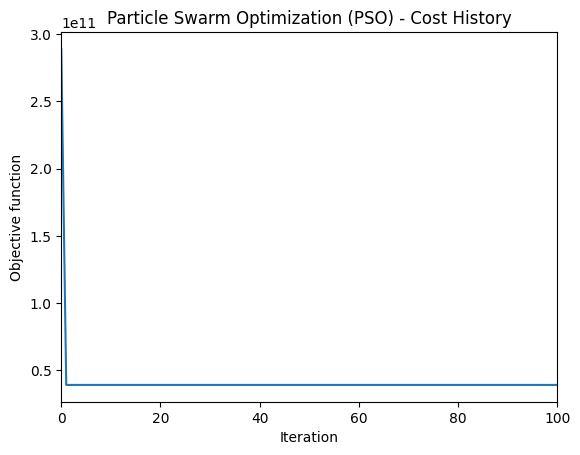

In [58]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')
plt.show()

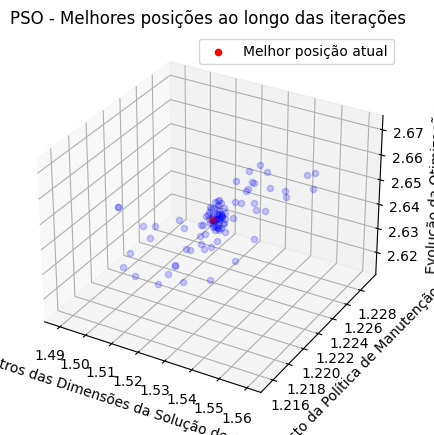

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: 320739635466.2723


In [75]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], best_positions[i, 2], c='blue', alpha=0.2)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], best_positions[-1, 2], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Parâmetros das Dimensões da Solução de Otimização')
ax.set_ylabel('Custo da Política de Manutenção')
ax.set_zlabel('Evolução da Otimização')
ax.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])